## Creating an Instability Matrix

This is the code for creating an instability matrix, using SAEs. Essentially, once we have extracted a specific feature that we think relates to a bias, we want to extract all weights that were responsible for triggering that bias and destabilize them. The instability matrix is a binary matrix that is "1" when a weight is likely responsible, and "0" otherwise.

First, we install necessary libraries, import them, and log onto HuggingFace.

In [ ]:
# Install necessary libraries
!pip install torch transformer_lens sae_lens datasets huggingface_hub

In [2]:
import torch
from transformer_lens import HookedTransformer
from sae_lens import SAE
from torch.optim import Adam

In [2]:
# Log onto Hugging Face (for model access)
from huggingface_hub import login
login()

In [4]:
# Specify device as CPU if possible
device = "cuda" if torch.cuda.is_available() else "cpu"


Then, we load our models.

We have chosen Gemma-2-2b as our LLM. This is because it is a small, open-source model, making it practical; and it is popular in research papers, making it easier for us to compare our work with others.

https://huggingface.co/google/gemma-2-2b

We have chosen Gemma Scope MLP as our SAE and are focusing on layer 12, as this SAE is pretrained and compatible with Gemma-2-2b, and easily interpretable on
Neuronpedia.

https://www.neuronpedia.org/gemma-2-2b/12-gemmascope-mlp-16k/

In [13]:
# Load the Gemma model (gemma-2-2b is small, making it practical, and it is popular in research papers)

model = HookedTransformer.from_pretrained(
    "google/gemma-2-2b",
    device=device,
    dtype=torch.bfloat16,
    checkpoint_value=None,
    device_map="auto",
    low_cpu_mem_usage=True
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


In [118]:
# Load the SAE

# This one is https://www.neuronpedia.org/gemma-2-2b/12-gemmascope-mlp-16k/
# And we use layer 12 as it is near the middle (25 layers total) and
# therefore likely to be meaningful

sae, sae_config, sparsity = SAE.from_pretrained(
    release="gemma-scope-2b-pt-mlp-canonical",
    sae_id="layer_12/width_16k/canonical",
    device=device
)

/tmp/ipython-input-1855/236027731.py:4: DeprecationWarning: Unpacking SAE objects is deprecated. SAE.from_pretrained() now returns only the SAE object. Use SAE.from_pretrained_with_cfg_and_sparsity() to get the config dict and sparsity as well.
  sae, sae_config, sparsity = SAE.from_pretrained(


In [123]:
def calculate_instability_matrix(
    model: HookedTransformer,
    sae: SAE, prompt: str,
    sae_config: dict[str: str | int | float],
    feature_idx: int,
    percent: float ) -> torch.Tensor:
  """
  Returns the instability matrix for a model showing which weights are
  most responsible for triggering the feature at the specified index.

  Implementation Notes:

  The instability matrix is calculayed using the feature activations of the
  given SAE. Only the top percent of weights are marked active (with "1") on
  the instability matrix.

  """
  # Get the output weight matrix for the LLM layer the SAE is attached to
  sae_input_hook = sae_config['metadata']['hook_name']
  layer_num = int(sae_input_hook.split('.')[1])
  target_weight = model.blocks[layer_num].mlp.W_out

  # Set up weight tracking for the LLM model weight matrix
  model.zero_grad()
  target_weight.requires_grad_(True)

  # Initialize dictionary to store LLM activations
  activations_storage = {}

  # Define a hook to store LLM activations and their gradients
  def store_activations(activations, hook):
      if activations.requires_grad:
          activations.retain_grad()
      activations_storage[hook.name] = activations
      return activations

  # Run the model with the hook
  model.run_with_hooks(
      prompt,
      fwd_hooks=[(sae_input_hook, store_activations)]
  )

  # Get sparse feature activations
  sae_acts = activations_storage[sae_input_hook]
  feature_actives = sae.encode(sae_acts)

  # Extract bias feature and trace feature activation to LLM weights
  bias_activation = feature_actives[0, :, feature_idx].sum()
  grads_tuple = torch.autograd.grad(outputs=bias_activation, inputs=target_weight)
  grads = grads_tuple[0]

  # Take abs value as high and low both indicate high impact of weights on ft.
  grads = grads.abs()

  # Initialize an instability matrix
  instability_matrix = torch.zeros_like(grads)

  # Mark the 1% of weights that are most active
  if grads.max() > 0:
        most_active = max(1, int(grads.numel() * percent))
        threshold = torch.topk(grads.flatten(), most_active).values[-1]
        instability_matrix[grads >= threshold] = 1.0

  model.zero_grad()
  return instability_matrix.detach()


In [122]:
test_prompt = "Women are worse at math than men"
test_feature_idx = 14089 # Appears random, but it is not! See next section.
test_percent = 0.0001 # Looking for top 0.01% of weights.

instability_matrix = calculate_instability_matrix(
    model=model,
    sae=sae,
    sae_config=sae_config,
    prompt=test_prompt,
    feature_idx=test_feature_idx,
    percent=test_percent
)

# Report number of unstable weights w.r.t total; print snippet of matrix
total_weights = instability_matrix.numel()
unstable_weights = int(instability_matrix.sum().item())
print(f"There are {unstable_weights} weights we must destabilize before bias intervention, out of {total_weights} total.")
print(instability_matrix)

There are 2128 weights we must destabilize before bias intervention, out of 21233664 total.
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.bfloat16)


## Finding Features Related to Bias

It is hard to know which features of an SAE correspond to what. Typically, we would have to test hypotheses with contrastive datasets, or some other more advanced method. However, Neuronpedia let's us do this easily and quickly.

For example, here is what feature 14809 actually means.

https://www.neuronpedia.org/gemma-2-2b/12-gemmascope-mlp-16k

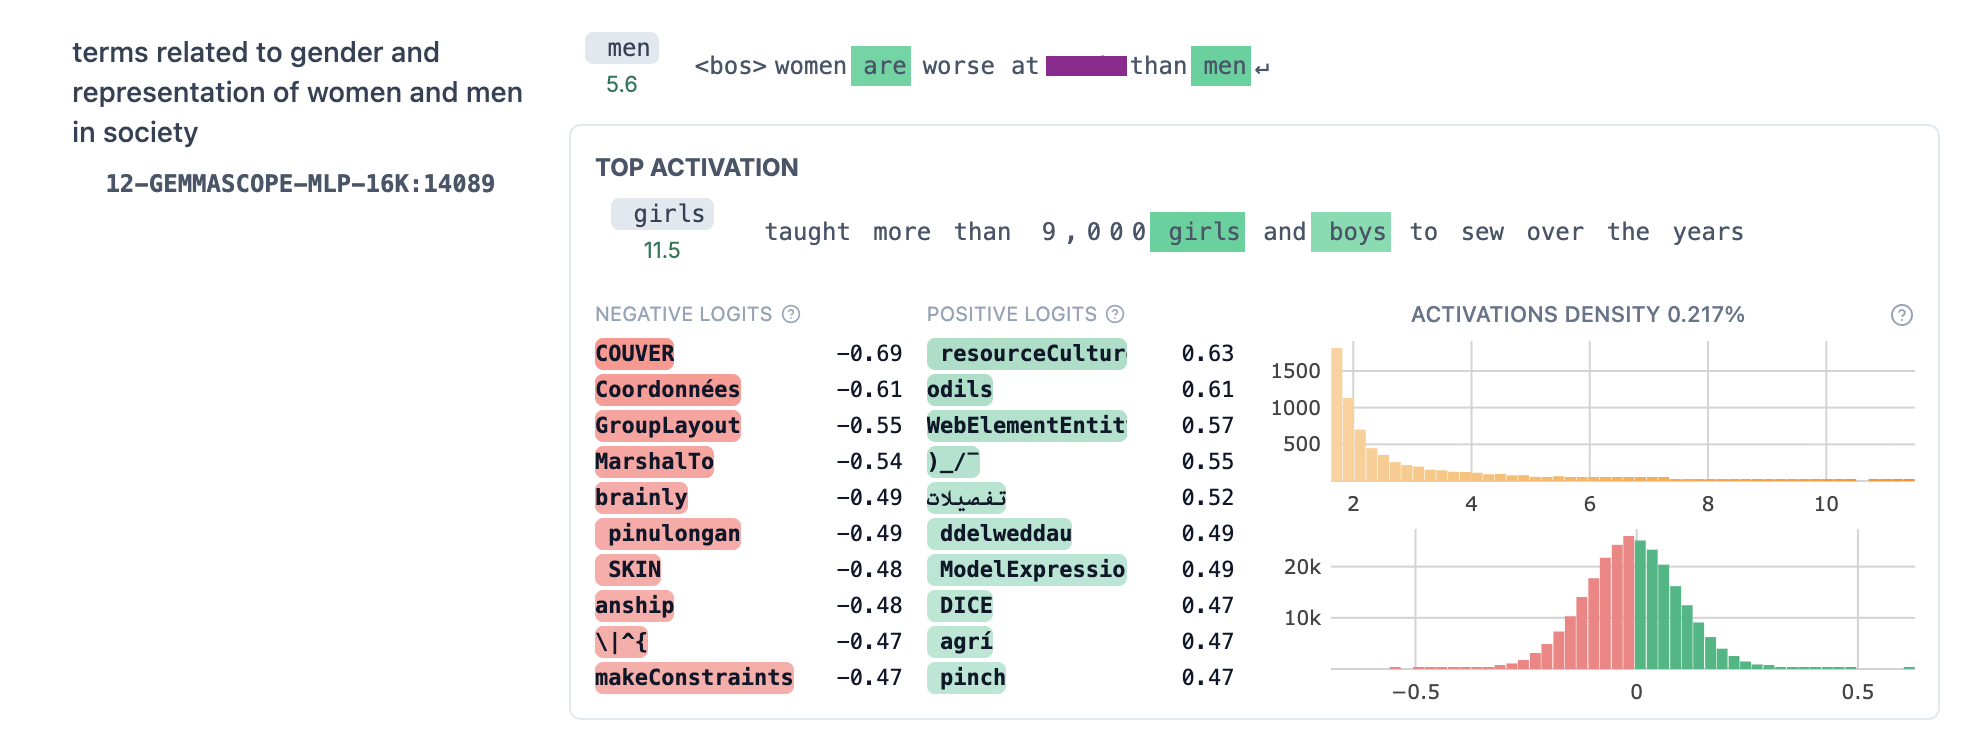

